## Imports

In [5]:
import re
import datetime
import os
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models, similarities
from gensim.test.utils import datapath
import gensim.models.ldamodel
import gensim
import re
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pysentiment as ps

## Global Values

Setting the folders to read the data from

In [6]:
# parent folder of the documents
parent_folder = ""
# folder to save pre-processed minutes in
pre_processed_folder = "pre_processed/"

Downloading the stemming algorithms dataset

In [7]:
nltk.download('punkt')
nltk.download('punkt')
nltk.download('english')
nltk.download('wordnet')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Defining different methods

Defining the function to analyze the data. Result is the average sentence length as well as the number of sentences and paragraphs overall.

In [8]:
def descriptive_analysis(lower_bound_date, upper_bound_date):
    folders = os.listdir(parent_folder + pre_processed_folder)
    data = []
    sentences = []
    paragraphs = []
    for folder in folders:
        files = os.listdir(parent_folder + pre_processed_folder + folder)
        for file in files:
            date = datetime.datetime(int(file[:4]), int(file[4:6]), int(file[6:8]))
            if date >= lower_bound_date and date <= upper_bound_date:
                paragraphs.append(file)
                file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", encoding='UTF-8')
                content = file_object.read()
                for sentence in nltk.sent_tokenize(content):
                    sentences.append(sentence)
                
    filtered_tokens = []
    for s in sentences:
        tokens = [word.lower() for word in nltk.word_tokenize(s)]
        for t in tokens:
            if re.search('[a-zA-Z]', t):
                filtered_tokens.append(t)
    avg_length = round(len(filtered_tokens)/len(sentences), 2)
    result = {"sentences":len(sentences), "paragraphs":len(paragraphs), "avg_sentence_length":avg_length}
    return result

Writing an algorithm to tokenize and stemm a given text using the PorterStemmer-algorithm. Returns a list with all stemmed words. Removing of stop words is done at another method.

In [9]:
def tokenize_and_stem(text):
    text = text.lower()
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    #stemmer = SnowballStemmer("english")
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    pos = nltk.pos_tag(tokens)
    for token in pos:
        if re.search('[a-zA-Z]', token[0]):
            if token[1].startswith('V'):
                #token = wordnet_lemmatizer.lemmatize(token[0], 'v')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
            elif token[1].startswith('A'):
                #token = wordnet_lemmatizer.lemmatize(token[0], 'a')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
            elif token[1].startswith('R'):
                #token = wordnet_lemmatizer.lemmatize(token[0], 's')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
            else:
                #token = wordnet_lemmatizer.lemmatize(token[0], 'n')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
    return filtered_tokens

Method to remove stopwords from a list of tokens. Stopwords a used from the NLTK library.

In [10]:
# remove all stop words (english) from a list of tokens
def remove_stopwords(tokens):
    filtered_words = [word for word in tokens if word.lower() not in stop_words]
    return filtered_words

Algorithm to find the 30 most common words in the dataset. For this cause the whole data is read in, stemmed and without stopwords. In the end the most common words are extracted from a list of tokens.

In [45]:
# read in all texts and identify the most common words (number specified in parameter)
from collections import Counter
def get_most_common_words(number = 100):
    word_list = []
    folders = os.listdir(parent_folder + pre_processed_folder)
    for folder in folders:
        files = os.listdir(parent_folder + pre_processed_folder + folder)
        for file in files:
            file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
            content = file_object.read()
            stems = tokenize_and_stem(content)
            words = [word for sent in nltk.sent_tokenize(content) for word in nltk.word_tokenize(sent)]
            words = remove_stopwords(words)
            for word in stems:
                word_list.append(word)
    counts = Counter(word_list)
    most_common_words = []
    for word in counts.most_common(number):
        most_common_words.append(word[0])
    return most_common_words

In [46]:
most_common_words = get_most_common_words(number = 30)

Combining the tokenizing and stemming with the remove of stopwords. Numbers, special symbols and words shorter than 3 symbols are removed as well. In general words creating an error while reading them in are just ignored. Therefore some foreign words and names are not included in the final dataset.

In [47]:
def preprocess_text(text):
    word_list = []
    stems = tokenize_and_stem(text)
    words = remove_stopwords(stems)
    for word in words:
        # Removing hyphens at the beginning and full stops at the end of words
        word = re.sub(re_full_stop, '', word)
        word = re.sub(re_hyphen, '', word)
        # No words containing numbers
        if not re.search(re_numbers, word):
            # remove words shoter than 2 symbols and most common words
            if len(word) > 2 and word not in most_common_words:
                word_list.append(word)
    return word_list

## Perform preparation (tokenization, lemmatization, removing of stop words + most common words) on the dataset

In [48]:
import datetime
re_full_stop = re.compile('\.+$')
re_hyphen = re.compile('^-+.*|-+$')
re_numbers = re.compile('.*[0-9]+.*')
folders = os.listdir(parent_folder + pre_processed_folder)
lemmatized_texts = []
for folder in folders:
    files = os.listdir(parent_folder + pre_processed_folder + folder)
    for file in files:
        date = datetime.datetime(int(file[:4]), int(file[4:6]), int(file[6:8]))
        # Using all data for training
        file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
        content = file_object.read()
        lemmatized_texts.append(preprocess_text(content))

## Descriptive Analysis

In [49]:
# Descriptive statistics for time range of paper
descriptive_analysis(datetime.datetime(2015, 1, 1), datetime.datetime(2022, 12, 31))

{'sentences': 6434, 'paragraphs': 1869, 'avg_sentence_length': 28.97}

## LDA

In [50]:
dictionary = corpora.Dictionary(lemmatized_texts)
dictionary.num_docs

1869

In [51]:
# passes: Number of passes through the entire corpus
# chunksize: Number of documents to load into memory at a time and process E step of EM.
# update_every: number of chunks to process prior to moving onto the M step of EM.
dictionary = corpora.Dictionary(lemmatized_texts)
dictionary.filter_extremes(no_below=20, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in lemmatized_texts]

# Model bereits berechnet und im nächsten Schritt aus dem Speicher geladen
lda = models.LdaModel(corpus, num_topics=8, 
                            id2word=dictionary, 
                            passes=150, 
                            chunksize=2000,
                            update_every = 1)

Optional saving and loading of lda models. Sometimes there are some unresolved mistakes in loading them.

In [36]:
lda_ecb_file = datapath("lda_ecb")
lda.save(lda_ecb_file)
# lda = models.LdaModel.load(lda_ecb_file)

Overview over the different topics and the most imports words for each of them.

In [52]:
lda.show_topics(30)

[(0,
  '0.042*"bond" + 0.028*"yield" + 0.020*"financ" + 0.018*"sinc" + 0.016*"meet" + 0.016*"increa" + 0.015*"declin" + 0.015*"purcha" + 0.014*"equiti" + 0.013*"curv"'),
 (1,
  '0.066*"quarter" + 0.021*"continu" + 0.019*"first" + 0.017*"second" + 0.017*"indic" + 0.016*"global" + 0.015*"data" + 0.012*"third" + 0.012*"point" + 0.012*"invest"'),
 (2,
  '0.028*"would" + 0.027*"purcha" + 0.021*"council" + 0.019*"councilâ€™" + 0.014*"asset" + 0.014*"thi" + 0.013*"app" + 0.013*"need" + 0.012*"sustain" + 0.011*"end"'),
 (3,
  '0.037*"loan" + 0.034*"bank" + 0.033*"credit" + 0.030*"lend" + 0.025*"continu" + 0.018*"condit" + 0.016*"household" + 0.014*"interest" + 0.014*"oper" + 0.014*"sector"'),
 (4,
  '0.066*"project" + 0.040*"staff" + 0.030*"outlook" + 0.027*"econom" + 0.021*"assess" + 0.019*"revi" + 0.018*"ecb" + 0.015*"eurosystem" + 0.014*"broadli" + 0.014*"continu"'),
 (5,
  '0.020*"also" + 0.019*"could" + 0.018*"measur" + 0.015*"effect" + 0.013*"thi" + 0.011*"structur" + 0.010*"wage" + 0.01

Using the lda model to calculate the propabilities for each paragraph. For each meeting the values are combined and standardized to 100%.

In [38]:
result = []
for folder in folders:
    files = os.listdir(parent_folder + pre_processed_folder + folder)
    date = str(folder)[:8]
    
    topic_proportion = [0, 0, 0, 0, 0, 0, 0, 0]
    number_elements = len(files)
    for file in files:
        file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
        content = file_object.read()
        preprocessed_text = preprocess_text(content)
        lda_result = lda[dictionary.doc2bow(preprocessed_text)]
        sum = 0
        for i in lda_result:
            sum = sum + i[1]
        for t in lda_result:
            topic_proportion[t[0]] = topic_proportion[t[0]] + t[1] / sum
    topic_proportion = [x / number_elements for x in topic_proportion]
    result.append([date, topic_proportion])

Merging different topics into four major topics: growth, inflation, financial markets, policy.

In [53]:
growth_mandate = []
inflation_mandate = []
financial_market_mandate = []
policy_mandate = []
dates = []
for r in result:
        dates.append(r[0])
        growth_mandate.append(r[1][2] + r[1][4] + r[1][5] + r[1][6])
        inflation_mandate.append(r[1][7])
        financial_market_mandate.append(r[1][3] + r[1][0])
        policy_mandate.append(r[1][1])

Plotting the results over time using a simple moving average with a timeframe of 3 periods.

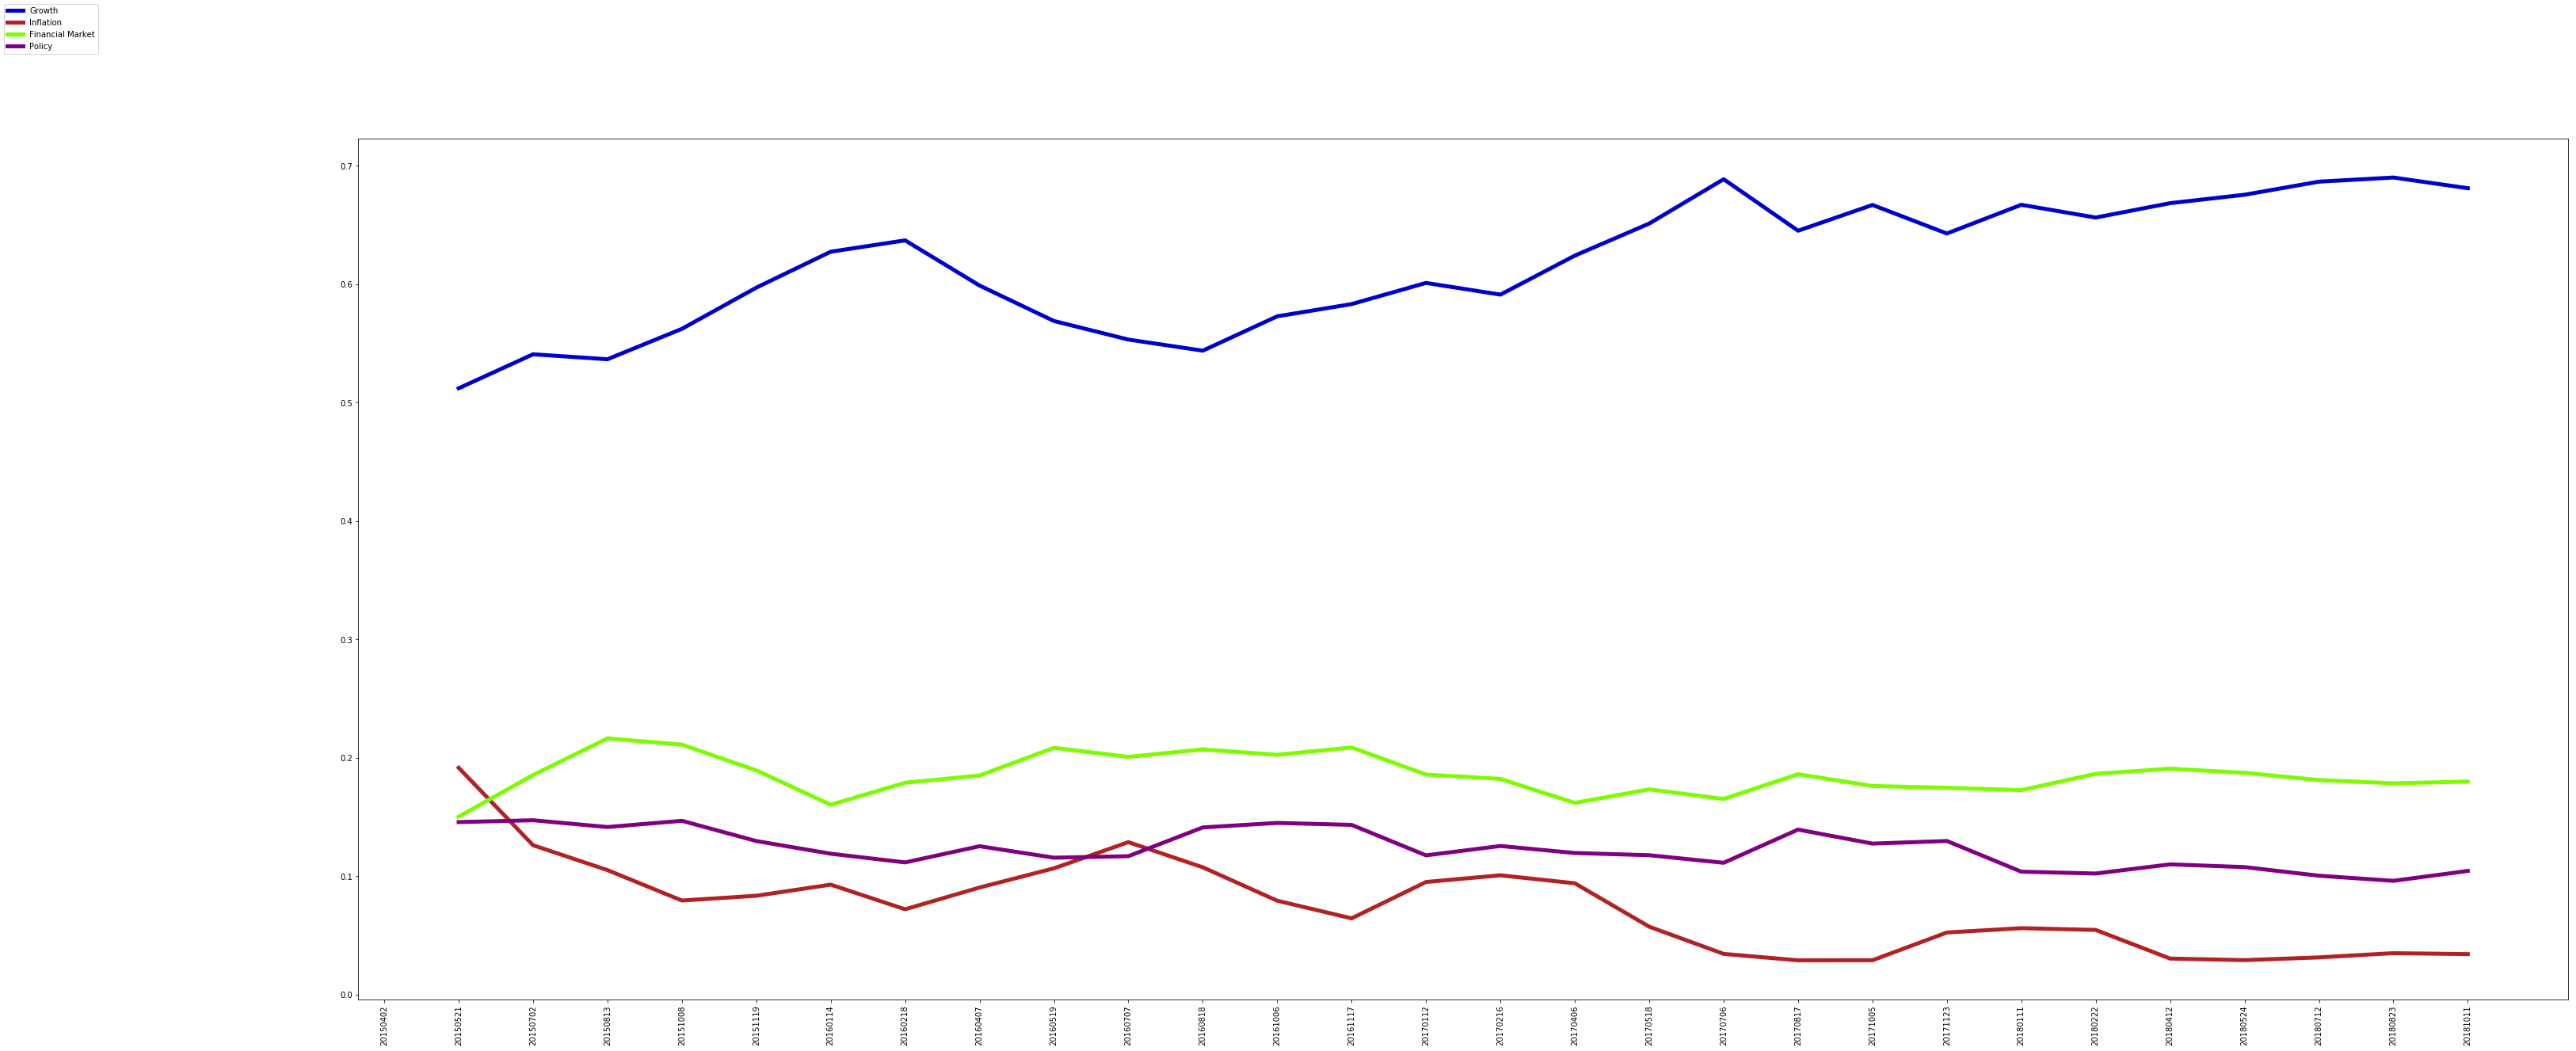

In [54]:
# FOMC Topic Proportions Over Time
import matplotlib
from scipy.interpolate import interp1d
x = dates
y1 = pd.Series.rolling(pd.Series(growth_mandate), 3).mean()
y2 = pd.Series.rolling(pd.Series(inflation_mandate), 3).mean()
y3 = pd.Series.rolling(pd.Series(financial_market_mandate), 3).mean()
y4 = pd.Series.rolling(pd.Series(policy_mandate), 3).mean()

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(111)
ax.plot(x, y1, color="mediumblue", linewidth=5, label="Growth")
ax.plot(x, y2, color="firebrick", linewidth=5, label="Inflation")
ax.plot(x, y3, color="lawngreen", linewidth=5, label="Financial Market")
ax.plot(x, y4, color="purple", linewidth=5, label="Policy")

fig.legend(loc='upper left', frameon=True)
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xticks()

## Extraction of conents

Loading of the used dictionaries (Harvard IV, Financial tonal list of Loughran and McDonald)

In [55]:
hiv4 = ps.HIV4()

C:\Users\lb4653\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (63,108,109,110,176) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Calculating the tones and uncertainty of each paragraph and aggregate the scores to the document level.

In [56]:
total_net_tone_scores = []
total_uncertainty_scores = []
for folder in folders:
    score_net_tone_document_level = [0, 0, 0, 0]
    score_uncertainty_document_level = [0, 0, 0, 0]
    files = os.listdir(parent_folder + pre_processed_folder + folder)
    date = str(folder)[:8]
    
    topic_proportion = [0, 0, 0, 0, 0, 0, 0, 0]
    number_elements = len(files)
    for file in files:
        #LDA
        file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
        content = file_object.read()
        preprocessed_text = preprocess_text(content)
        lda_result = lda[dictionary.doc2bow(preprocessed_text)]
        sum = 0
        for i in lda_result:
            sum = sum + i[1]
        growth = 0
        inflation = 0
        financial = 0
        policy = 0
        
        # Setting the parameters to assign the correct topic to each result
        for r in lda_result:
            if (r[0] == 2 or r[0] == 4 or r[0] == 5 or r[0] == 6):
                growth = growth + r[1]
            elif r[0] == 7:
                inflation = inflation + r[1]
            elif r[0] == 0 or r[0] == 3:
                financial = financial + r[1]
            else:
                policy = policy + r[1]
        
        # Content Extraction
        tokens = hiv4.tokenize(content)
        score = hiv4.get_score(tokens)
        F = [score['Positive'] - score['Negative'], score['Polarity']]
       
        # Calculating Scores for net tone and uncertainty
        # Reverse tone for inflation mandate
        score_net_tone = [t * F[0] for t in [growth, -inflation, financial, policy]]
        score_uncertainty = [t * F[1] for t in [growth, inflation, financial, policy]]   
        
        
        # Calculating scores at document level
        for i in range(0, 4):
            score_net_tone_document_level[i] = score_net_tone_document_level[i] + score_net_tone[i] / len(tokens)
            score_uncertainty_document_level[i] = score_uncertainty_document_level[i] + score_uncertainty[i] / len(tokens)
            
    # save document scores in lists - each entry is corresponding with one date
    total_net_tone_scores.append(score_net_tone_document_level)
    total_uncertainty_scores.append(score_uncertainty_document_level)

Standardizing the values to a mean of zero and standard deviation of one.

In [57]:
# Normalizing values of net tone scores
net_tone_scores_growth = [t[0] for t in total_net_tone_scores]
growth_mean = np.mean(net_tone_scores_growth)
growth_sd = np.std(net_tone_scores_growth)
net_tone_scores_growth = [(t - growth_mean) / growth_sd for t in net_tone_scores_growth]

net_tone_scores_inflation = [t[1] for t in total_net_tone_scores]
inflation_mean = np.mean(net_tone_scores_inflation)
inflation_sd = np.std(net_tone_scores_inflation)
net_tone_scores_inflation = [(t - inflation_mean) / inflation_sd for t in net_tone_scores_inflation]

net_tone_scores_financial = [t[2] for t in total_net_tone_scores]
financial_mean = np.mean(net_tone_scores_financial)
financial_sd = np.std(net_tone_scores_financial)
net_tone_scores_financial = [(t - financial_mean) / financial_sd for t in net_tone_scores_financial]

net_tone_scores_policy = [t[3] for t in total_net_tone_scores]
policy_mean = np.mean(net_tone_scores_policy)
policy_sd = np.std(net_tone_scores_policy)
net_tone_scores_policy = [(t - policy_mean) / policy_sd for t in net_tone_scores_policy]

In [58]:
# Normalizing values of uncertainty scores
uncertainty_scores_growth = [t[0] for t in total_uncertainty_scores]
growth_mean = np.mean(uncertainty_scores_growth)
growth_sd = np.std(uncertainty_scores_growth)
uncertainty_scores_growth = [(t - growth_mean) / growth_sd for t in uncertainty_scores_growth]

uncertainty_scores_inflation = [t[1] for t in total_uncertainty_scores]
inflation_mean = np.mean(uncertainty_scores_inflation)
inflation_sd = np.std(uncertainty_scores_inflation)
uncertainty_scores_inflation = [(t - inflation_mean) / inflation_sd for t in uncertainty_scores_inflation]

uncertainty_scores_financial = [t[2] for t in total_uncertainty_scores]
financial_mean = np.mean(uncertainty_scores_financial)
financial_sd = np.std(uncertainty_scores_financial)
uncertainty_scores_financial = [(t - financial_mean) / financial_sd for t in uncertainty_scores_financial]

uncertainty_scores_policy = [t[3] for t in total_uncertainty_scores]
policy_mean = np.mean(uncertainty_scores_policy)
policy_sd = np.std(uncertainty_scores_policy)
uncertainty_scores_policy = [(t - policy_mean) / policy_sd for t in uncertainty_scores_policy]

Plotting the net tone scores over time

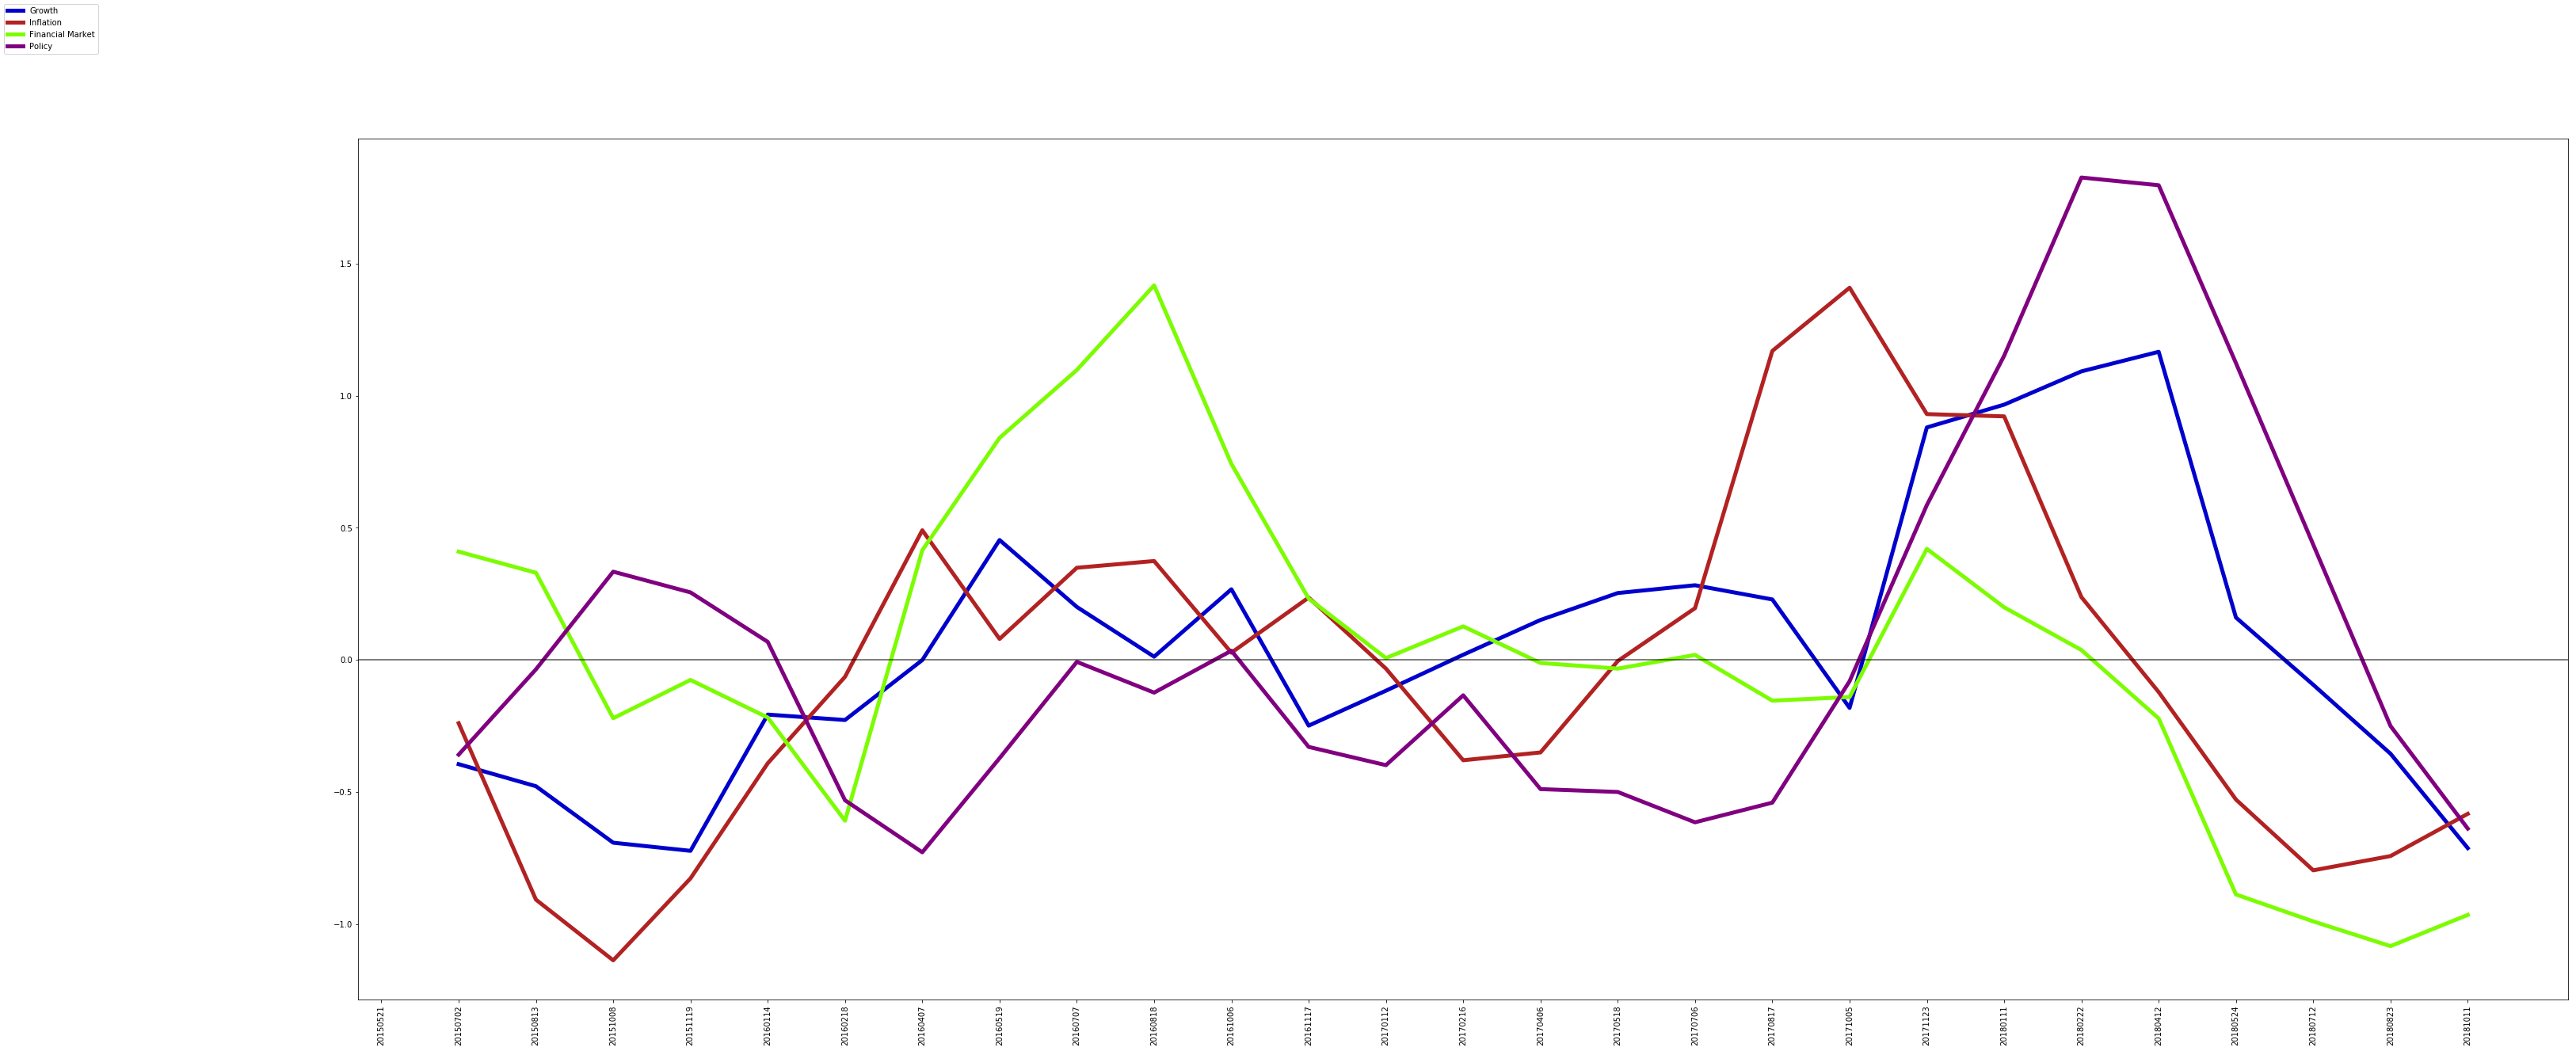

In [59]:
x = dates
y1 = pd.Series.rolling(pd.Series(net_tone_scores_growth), 4).mean()
y2 = pd.Series.rolling(pd.Series(net_tone_scores_inflation), 4).mean()
y3 = pd.Series.rolling(pd.Series(net_tone_scores_financial), 4).mean()
y4 = pd.Series.rolling(pd.Series(net_tone_scores_policy), 4).mean()


fig3 = plt.figure(figsize=(50, 20))
ax3 = fig3.add_subplot(111)
ax3.plot(x, y1, color="mediumblue", linewidth=5, label="Growth")
ax3.plot(x, y2, color="firebrick", linewidth=5, label="Inflation")
ax3.plot(x, y3, color="lawngreen", linewidth=5, label="Financial Market")
ax3.plot(x, y4, color="purple", linewidth=5, label="Policy")

ax3.axhline(0, color="black", linewidth=2, alpha=0.5)

fig3.legend(loc='upper left', frameon=True)
for ax in fig3.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xticks()

Plotting the unvertainty scores over time

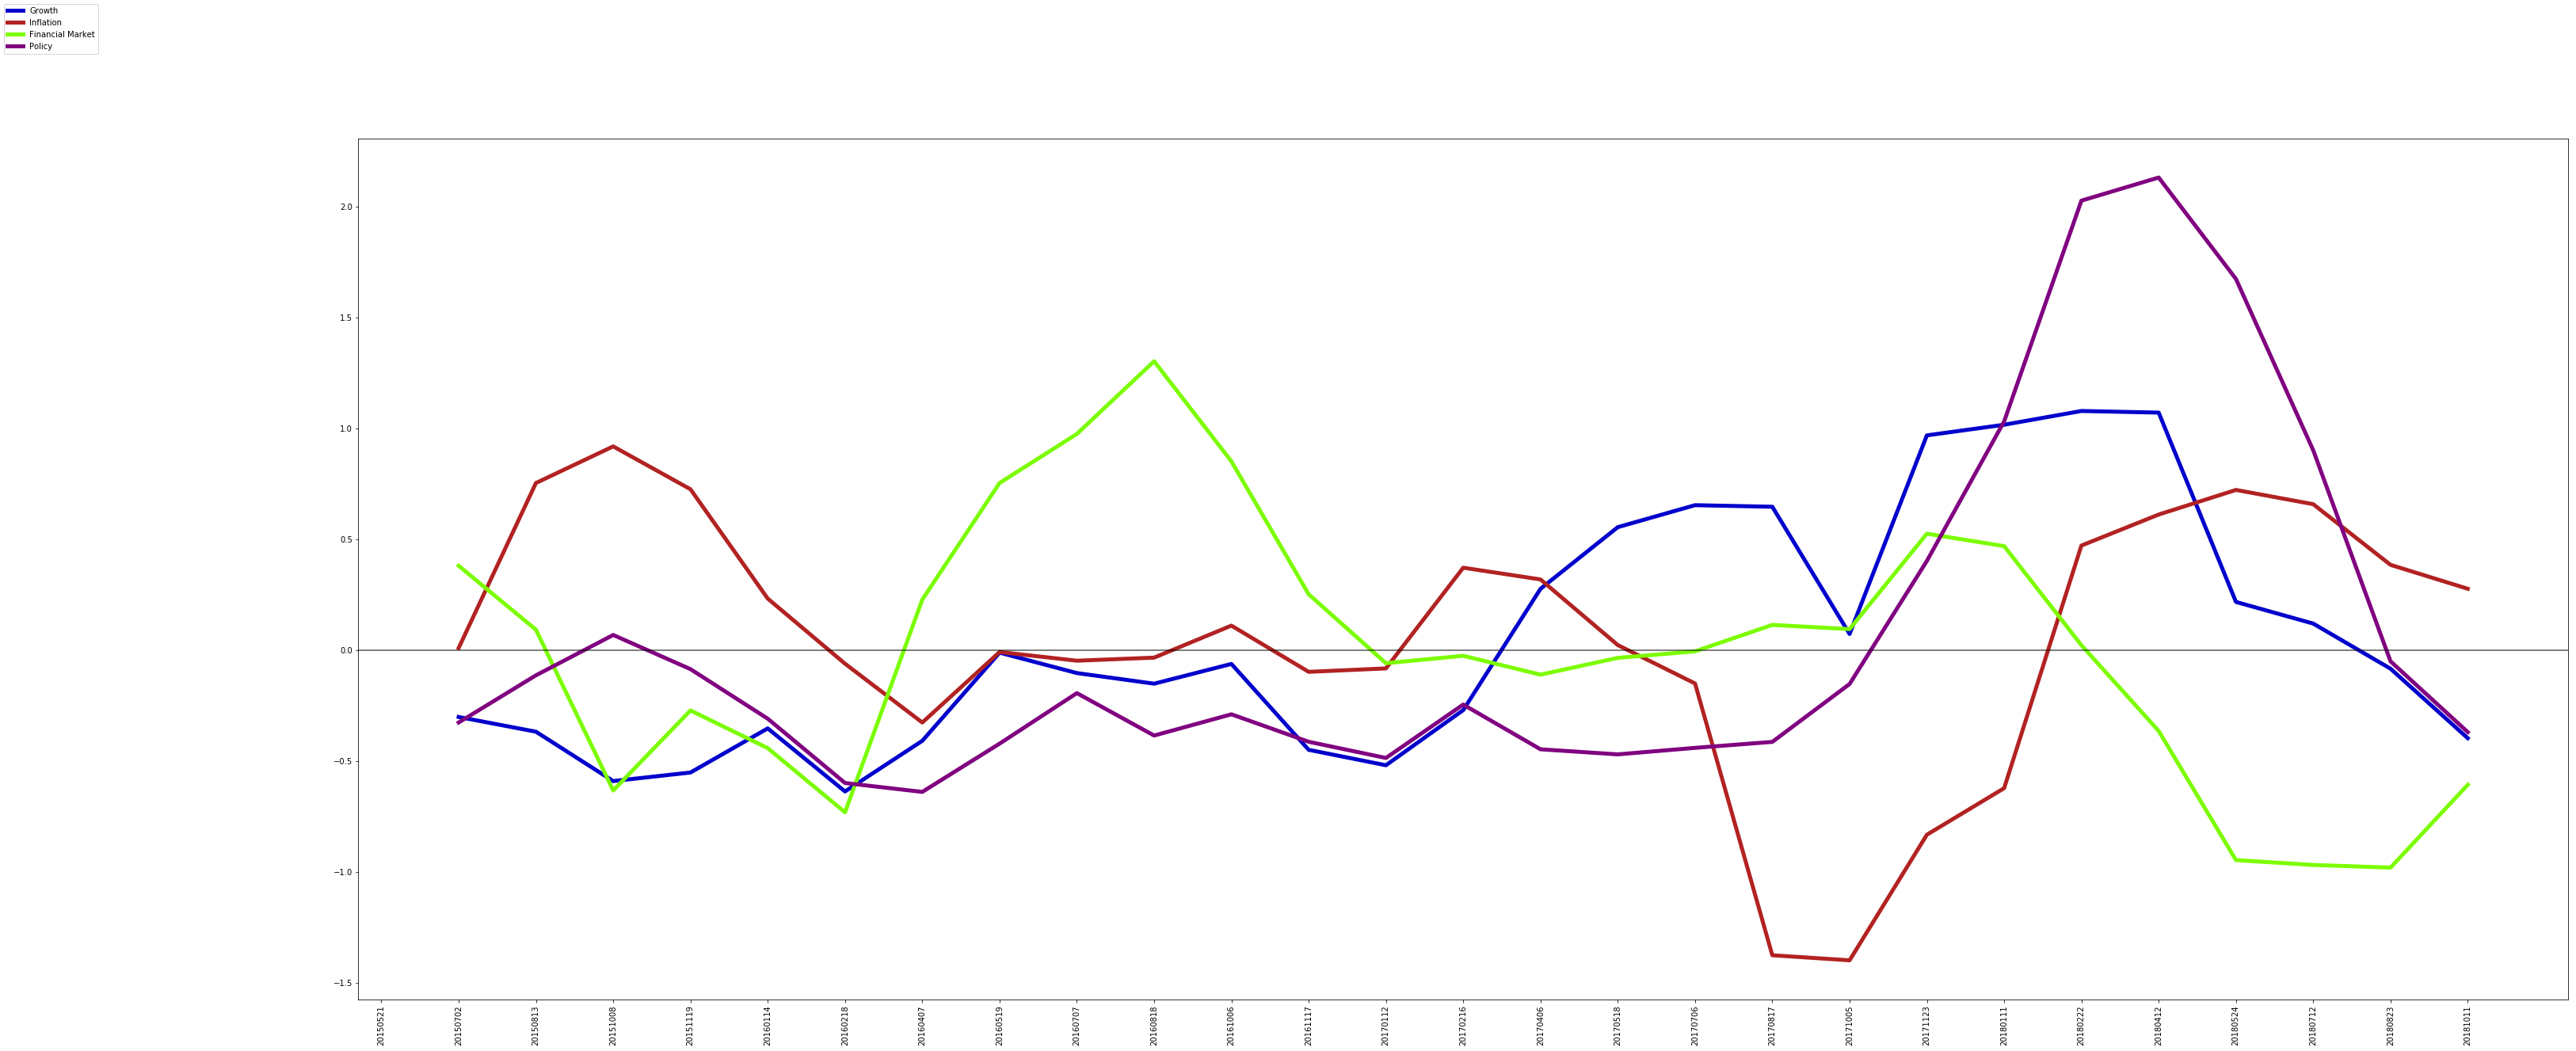

In [60]:
x = dates
y1 = pd.Series.rolling(pd.Series(uncertainty_scores_growth), 4).mean()
y2 = pd.Series.rolling(pd.Series(uncertainty_scores_inflation), 4).mean()
y3 = pd.Series.rolling(pd.Series(uncertainty_scores_financial), 4).mean()
y4 = pd.Series.rolling(pd.Series(uncertainty_scores_policy), 4).mean()


fig4 = plt.figure(figsize=(50, 20))
ax4 = fig4.add_subplot(111)
ax4.plot(x, y1, color="mediumblue", linewidth=5, label="Growth")
ax4.plot(x, y2, color="firebrick", linewidth=5, label="Inflation")
ax4.plot(x, y3, color="lawngreen", linewidth=5, label="Financial Market")
ax4.plot(x, y4, color="purple", linewidth=5, label="Policy")

ax4.axhline(0, color="black", linewidth=2, alpha=0.5)

fig4.legend(loc='upper left', frameon=True)
for ax in fig4.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xticks()